In [ ]:
# default_exp predict

# Predict

> Prediction and export outputs.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *
from steel_segmentation.dataloaders import *
from steel_segmentation.metrics import *
from steel_segmentation.trainer import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import os
import cv2
import pathlib
import numpy as np
import pandas as pd
import warnings
import zipfile
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset, sampler
import albumentations as alb

import segmentation_models_pytorch as smp

warnings.filterwarnings("ignore")

pred_path = path / "predictions"
sub_path = path / "submissions"
pred_path.mkdir(parents=True, exist_ok=True)
sub_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

In [ ]:
# missing
print_competition_data(models_dir)

../models/kaggle-FPN-ResNet34-finetuning.pth
../models/ResNet18-Unet-kaggle.pth
../models/.ipynb_checkpoints
../models/ResNet18-Classifier-kaggle.pth
../models/kaggle-FPN-ResNet34.pth
../models/ResNet34-Unet-256-stage5.pth
../models/ResNet34-Unet-256-stage3.pth


## Fast.ai prediction

In [ ]:
arch = resnet34
bs = 4 
dls = get_segmentation_dls_from_df(train_df=train_multi, bs=bs, size=(256, 1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

In [ ]:
# missing
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage3")

In [ ]:
# export
class FastPredict:
    pred_mask_path = pred_path / "prediction_masks"
    
    def get_df_source_list(self):
        """Load `source` if it's a DataFrame instance."""
        tfm = ColReader("ImageId", pref=self.source_path)
        return L([tfm(o) for o in self.source.itertuples()])
        
    def get_path_source_list(self):
        """Load `source` if it's a pathlib.Path instance."""
        return get_image_files(self.source)
    
    def __init__(self, 
                 source, 
                 learner,
                 source_path:pathlib.Path=None):
        """
        A FastPredict object has:
        - source: key to load a list of images
        - learner: a fastai Learner object
        - source_path: the folder path to the images 
        """
        self.source = source 
        self.learner = learner
        self.source_path = source_path if source_path else train_path
        
        self.single_prediction = False
        
        if isinstance(self.source, pathlib.Path):
            self.img_paths = self.get_path_source_list()
        elif isinstance(self.source, pd.DataFrame):
            self.img_paths = self.get_df_source_list()
        elif isinstance(self.source, list):
            self.img_paths = self.source
        elif isinstance(self.source, str):
            self.single_prediction = True
            self.img_paths = L(self.source_path / self.source)

        self.elems = len(self.img_paths)
    
    def __call__(self, size_fold:int, threshold:float, min_size:int):
        """Call the object with prediction attributes, 
        it calls `Predict.get_predictions`
        and returns the `Predict.df` DataFrame with RLEs."""
        self.size_fold = min([self.elems, size_fold])
        self.threshold = threshold
        self.min_size = min_size
        self.folds = self.elems // self.size_fold
        
        if (self.elems % self.size_fold) != 0:
            self.folds += 1
            
        self.df = self.get_predictions()
        return self.df
    
    def get_predictions(self):
        """Iterate through `Predict.folds`, predict the mask and
        get the RLEs in a DataFrame."""
        df_preds = []
        
        for fold in range(self.folds):
            start, end = fold*self.size_fold, (fold+1)*self.size_fold
            print(f"From {start} to {end} of {self.elems}")
            
            selected_imgs = self.img_paths[start:end]
            
            img_names = selected_imgs.map(Path).map(lambda x: x.name)
            pred_probs = self.predict(selected_imgs)            
            
            tmp_df = self.get_RLEs(img_names, pred_probs)
            df_preds.append(tmp_df)

            torch.cuda.empty_cache()
        
        if len(df_preds) == 1:
            return df_preds[0]
        
        df = pd.concat(df_preds, axis=0, ignore_index=True)
        return df.fillna("")
    
    def predict(self, selected_imgs):
        """Get the predictions on the `selected_imgs`."""
        if self.single_prediction:
            pred_full_dec, pred_dec, out = self.learner.predict(selected_imgs[0])
            return out.unsqueeze(dim=0)
            
        test_dl = self.learner.dls.test_dl(test_items=selected_imgs)
        pred_probs,_,_ = self.learner.get_preds(dl=test_dl, with_decoded=True)
        
        return pred_probs
    
    def get_RLEs(self, img_names, pred_probs):
        """For each image in the batch to predict, 
        returns a list of tuples with `(img_id, rle)`."""
        predictions = []
        
        for num_pred, t_pred in enumerate(pred_probs): # img in bs
            np_pred = t_pred.numpy()

            # iterate through class_id without class_id 0
            for class_id, prob in enumerate(np_pred[1:]): 
                pred, num = self.post_process(prob)
                rle = mask2rle(pred)
                name = img_names[num_pred] + f"_{class_id+1}"
                predictions.append([name, rle])
        
        return pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
    
    def post_process(self, probability):
        """
        Post processing of each predicted mask, components with lesser number of pixels
        than `min_size` are ignored.
        """
        mask = cv2.threshold(probability, self.threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        predictions = np.zeros((256, 1600), np.float32)
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > self.min_size:
                predictions[p] = 1
                num += 1
        return predictions, num
    
    def save_masks(self, df_export_fname=None, make_zip=True):
        """
        If `df_export_fname` save predicted masks in 
        `pred_path / df_export_fname` in CSV and the JSON.
        Otherwise the file are named "predictions.csv" and "predictions.json".
        Saving the zip of the masks if `make_zip`.
        
        Run this method after __call__.
        """
        if not hasattr(self, 'df'):
            print("Predictions missing. Call the Prediction object first!")
            raise KeyError("Missing self.df, first run self.__call__ to get predictions")
        
        self.df_masks = self.make_masks()
        
        if not df_export_fname:
            df_export_fname = "predictions"
            
        csv_name = pred_path/(df_export_fname + ".csv")
        json_name = pred_path/(df_export_fname + ".json")
        self.df_masks.to_csv(csv_name, index=False)
        self.df_masks.to_json(json_name, orient="table", indent=4)
        
        if make_zip:
            zip_fname = df_export_fname + ".zip"
            with zipfile.ZipFile(pred_path/zip_fname, 'w', zipfile.ZIP_DEFLATED) as zipf:
                self.zipdir(zipf)
            
    def make_masks(self):
        """
        Iterate through the RLEs in `Predict.df` and save the masks.
        Returns the `Predict.df_masks` DataFrame (if not `json`) with
        `columns=['ImageId', 'ClassId', 'Mask_path']`.
        """
        self.pred_mask_path.mkdir(parents=True, exist_ok=True)

        rows = []
        for row in self.df.itertuples():
            if row.EncodedPixels != '':
                img_id, class_id = row.ImageId_ClassId.split("_")
                img_id = img_id.split(".")[0]
                img_label = img_id + "_pred.png"
                img_path = self.pred_mask_path / img_label

                mask = rle2mask(row.EncodedPixels, 1, (256, 1600))
                im = Image.fromarray(mask)
                im.save(img_path)

                rows.append((img_id + ".jpg", class_id, img_label))
        
        return pd.DataFrame(rows, columns=['ImageId', 'ClassId', 'Mask_path'])
    
    def zipdir(self, ziph:zipfile.ZipFile, pfolder=None):
        """Zip the current `self.pred_mask_path` directory,
        otherwise zip the `path` dir if provided."""
        if not pfolder:
            pfolder = self.pred_mask_path

        if not isinstance(pfolder, pathlib.Path):
            pfolder = Path(pfolder)

        for root,dirs,files in os.walk(pfolder):
            root = Path(root)
            for file in files:
                fname = root / file
                ziph.write(filename=fname,
                           arcname =os.path.relpath(fname,fname.parent))
                
    def save_submission(self, fname="test_submission"):
        """Save submission file in CSV in `sub_path`. 
        It adds always .csv at the end of `fname`."""
        if not hasattr(self, 'df'):
            raise KeyError("Call the object first to get the predictions")
        
        file_path = sub_path / (fname + '.csv')
        self.df.to_csv(file_path, index=False)
    
#    def plot(self, n:int=5, rand=False):
#        """Plot `n` elements in `self.img_paths`. 
#        If `rand` prints shuffle images."""
#        if (not hasattr(self, 'df_masks'))|(not hasattr(self, 'df')):
#            return "Nothing to plot, first call make_masks"

#        path_list = self.img_paths.map(Path)
        
#        if rand:
            #path_list = get_perm_imgs_path(self.img_paths.map(Path), self.df_masks)   
#            path_list = path_list.shuffle()
            
#        df = self.df.copy()
#        splitted_cols = df["ImageId_ClassId"].str.split("_", expand=True)
#        df["ImageId"], df["ClassId"] = splitted_cols[0], splitted_cols[1].astype("int64")
        
#        for p in path_list[:n]:
#            imgid, mask = make_mask(p, flatten=True, df=df)
#            img = cv2.imread(str(p))
#            plot_mask_image(imgid, img, mask)

The `Predict` class needs a `source` and a `source_path` when `source` is:
- a `str` for the `ImageId` of a single image
- a dataframe with the `ImageId` column.

Otherwise `source` can be a list (`L`) of paths or a single `Path` object.

How to use:
1. Setup the `Predict` class: create an instance with `pred = Predict(*args)`.
2. Call the object (e.g. `pred`) with the parameters: `size_fold` is the number of elements to infer toghether, `threshold` is the threshold for the probabilities from the activation function, `min_size` needs to ignore components in the predicted masks with few number of pixels (to reduce the false positive rate).
3. Get the predictions `DataFrame` with the `ImageId_ClassId` and the `EncodedPixels` columns.

In [ ]:
df_tmp = segmentation_learner.dls.valid.items.iloc[:5]
print(df_tmp.shape)

pred = FastPredict(df_tmp, segmentation_learner) # with a pd.DataFrame source

(5, 2)


In [ ]:
show_doc(FastPredict.__call__)

<h4 id="FastPredict.__call__" class="doc_header"><code>FastPredict.__call__</code><a href="__main__.py#L36" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.__call__</code>(**`size_fold`**:`int`, **`threshold`**:`float`, **`min_size`**:`int`)

Call the object with prediction attributes, 
it calls [`Predict.get_predictions`](/steel_segmentation/predict.html#Predict.get_predictions)
and returns the [`Predict.df`](/steel_segmentation/predict.html#Predict.df) DataFrame with RLEs.

In [ ]:
size_fold = 100
threshold = 0.5
min_size = 3000

In [ ]:
df_pred = pred(size_fold, threshold, min_size)
print(df_pred.shape)
df_pred.head()

In [ ]:
df_tmp = train.iloc[0].to_frame().T # one element
print(df_tmp.shape)

pred = FastPredict(df_tmp, segmentation_learner)

df_pred = pred(size_fold, threshold, min_size)
df_pred

(1, 4)
From 0 to 1 of 1


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,77411 11 77665 17 77918 20 78172 24 78427 26 78681 31 78937 30 79194 32 79229 1 79231 7 79239 1 79241 1 79271 1 79273 1 79275 1 79277 1 79279 1 79281 1 79283 1 79449 33 79485 1 79487 1 79489 9 79499 1 79519 1 79521 1 79523 1 79525 1 79527 1 79529 13 79543 1 79705 53 79759 1 79771 1 79773 31 79962 31 79996 1 79999 14 80015 1 80019 1 80021 1 80023 1 80025 35 80218 31 80255 3 80259 11 80271 48 80474 31 80513 13 80527 1 80529 1 80531 1 80533 43 80730 32 80767 67 80987 30 81024 1 81027 2 81030 3 81034 1 81036 1 81040 1 81043 46 81243 30 81279 15 81295 2 81299 47 81499 29 81538 1 81540 1 81542 1...
1,0002cc93b.jpg_2,
2,0002cc93b.jpg_3,
3,0002cc93b.jpg_4,


In [ ]:
source = "f383950e8.jpg"
pred = FastPredict(source, segmentation_learner) # with str source
df_pred = pred(size_fold, threshold, min_size)
df_pred

From 0 to 1 of 1


,ImageId_ClassId,EncodedPixels
0,f383950e8.jpg_1,
1,f383950e8.jpg_2,
2,f383950e8.jpg_3,69000 11 69012 1 69191 7 69239 3 69243 35 69279 1 69440 19 69464 78 69696 20 69719 79 69952 22 69975 80 70207 106 70463 110 70717 110 70973 110 71229 114 71485 114 71739 114 71995 114 72249 116 72505 115 72757 1 72759 44 72807 68 73011 1 73013 46 73064 66 73265 50 73321 64 73521 50 73577 64 73776 51 73833 62 74032 52 74089 62 74288 119 74543 120 74800 117 75056 117 75311 118 75567 118 75823 118 76079 118 76335 118 76590 119 76846 119 77102 119 77358 118 77614 118 77870 117 78126 117 78381 117 78637 116 78893 116 79149 115 79405 112 79661 111 79917 104 80173 103 80429 73 80503 26 80685 71 8...
3,f383950e8.jpg_4,314091 20 314344 24 314592 33 314847 34 315093 44 315348 45 315595 54 315847 58 316099 62 316353 64 316604 69 316859 70 317113 72 317367 74 317615 2 317618 79 317871 82 318119 90 318374 91 318622 99 318878 99 319118 115 319374 115 319620 125 319875 126 320129 128 320383 130 320635 134 320891 134 321144 1 321146 135 321399 138 321652 141 321907 142 322159 146 322415 146 322667 150 322923 150 323172 1 323174 155 323428 157 323680 161 323935 162 324184 1 324186 167 324440 169 324692 173 324947 174 325199 178 325455 178 325708 181 325963 182 326216 185 326471 186 326723 190 326979 190 327231 1...


In [ ]:
show_doc(FastPredict.make_masks)

<h4 id="FastPredict.make_masks" class="doc_header"><code>FastPredict.make_masks</code><a href="__main__.py#L154" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.make_masks</code>()

Iterate through the RLEs in [`Predict.df`](/steel_segmentation/predict.html#Predict.df) and save the masks.
Returns the [`Predict.df_masks`](/steel_segmentation/predict.html#Predict.df_masks) DataFrame (if not `json`) with
`columns=['ImageId', 'ClassId', 'Mask_path']`.

In [ ]:
pred.make_masks()

,ImageId,ClassId,Mask_path
0,f383950e8.jpg,3,f383950e8_pred.png
1,f383950e8.jpg,4,f383950e8_pred.png


In [ ]:
show_doc(FastPredict.save_masks)

<h4 id="FastPredict.save_masks" class="doc_header"><code>FastPredict.save_masks</code><a href="__main__.py#L126" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.save_masks</code>(**`df_export_fname`**=*`None`*, **`make_zip`**=*`True`*)

If `df_export_fname` save predicted masks in 
`pred_path / df_export_fname` in CSV and the JSON.
Otherwise the file are named "predictions.csv" and "predictions.json".
Saving the zip of the masks if `make_zip`.

Run this method after __call__.

In [ ]:
pred.save_masks()

In [ ]:
pred_path.ls()

(#6) [Path('../data/predictions/prediction_masks'),Path('../data/predictions/predictions.csv'),Path('../data/predictions/validation_masks.json'),Path('../data/predictions/predictions.zip'),Path('../data/predictions/validation_masks.csv'),Path('../data/predictions/predictions.json')]

In [ ]:
show_doc(FastPredict.save_submission)

<h4 id="FastPredict.save_submission" class="doc_header"><code>FastPredict.save_submission</code><a href="__main__.py#L194" class="source_link" style="float:right">[source]</a></h4>

> <code>FastPredict.save_submission</code>(**`fname`**=*`'test_submission'`*)

Save submission file in CSV in [`sub_path`](/steel_segmentation/predict.html#sub_path). 
It adds always .csv at the end of `fname`.

In [ ]:
pred.save_submission()

In [ ]:
tmp_path = sub_path/"test_submission.csv"
assert tmp_path.is_file()

In [ ]:
#hide
# show_doc(FastPredict.plot)

In [ ]:
#hide
#pred.plot(n=1, rand=False)

## Pytorch prediction

In [ ]:
# export
class TestDataset(Dataset):
    """Dataset for test prediction"""

    def __init__(self, root, df, mean, std):
        """
        A TestDataset loads the images from the `root` folder
        and the `ImageId`s from `df` with normalization params.
        """
        self.root = root
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = alb.Compose(
            [
                alb.Normalize(mean=mean, std=std, p=1),
                alb.pytorch.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        fpath = self.root / fname
        image = cv2.imread(str(fpath))
        image_tensor = self.transform(image=image)["image"]
        return fname, image_tensor

    def __len__(self):
        return self.num_samples

In [ ]:
test_dataset = TestDataset(train_path, train_multi, *imagenet_stats)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0002cc93b.jpg


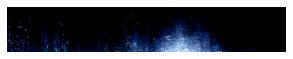

In [ ]:
# missing
img_name, img_tensor = test_dataset[0]
print(img_name)
show_image(img_tensor);

In [ ]:
# export
def get_test_dls(
        root = None,
        df = None,
        best_threshold=0.5, 
        num_workers=2, 
        batch_size=4, 
        min_size=3500, 
        mean=None, std=None,
        *args, **kwargs
    ):
    """Returns dataloader for testing."""
    if not mean and not std: mean, std = imagenet_stats
    if df is None: df = test_df
    if not root: root = test_path
    
    return DataLoader(
        TestDataset(root, df, mean, std),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        *args, **kwargs
    )

In [ ]:
# missing
test_dls = get_test_dls()
test_eq(len(test_dls), 1377)

In [ ]:
# missing
xb, yb = next(iter(test_dls))
xb[0], yb[0].shape

('0000f269f.jpg', torch.Size([3, 256, 1600]))

In [ ]:
# export
class Predict:
    def __init__(self, test_dl, model, device="cuda"):
        """
        `test_dl`: test Dataloader already loaded with `get_test_dls`
        """
        self.test_dl = test_dl
        self.source = self.test_dl.dataset.fnames
        self.source_path = self.test_dl.dataset.root
        self.img_paths = L([self.source_path / p for p in self.source])
        self.elems = len(self.img_paths)

        self.device = torch.device(device)
        self.model = model.to(self.device)
        
        
    def __call__(self, threshold:float, min_size:int):
        """
        Call the object with prediction attributes, 
        it calls `Predict.get_predictions`
        and returns the `Predict.df` DataFrame with RLEs.
        """
        self.threshold = threshold
        self.min_size = min_size      
        self.df = self.get_predictions()
        return self.df
    
    def get_predictions(self):
        """
        Iterate through `test_dl`, predict the mask and
        save the RLEs in a DataFrame.
        Returns the DataFrame.
        """
        df_preds = []
        for i, batch in enumerate(tqdm(self.test_dl)):
            fnames, images = batch
            
            batch_preds = torch.sigmoid(self.model(images.to(self.device)))
            batch_preds = batch_preds.detach().cpu().numpy()
            
            for fname, preds in zip(fnames, batch_preds):
                for cls, pred in enumerate(preds):
                    pred, num = self.post_process(pred)
                    rle = mask2rle(pred)
                    name = fname + f"_{cls+1}"
                    df_preds.append([name, rle])
                    
        return pd.DataFrame(df_preds, columns=['ImageId_ClassId', 'EncodedPixels'])
    
    def post_process(self, probability):
        """
        Post processing of each predicted mask, components with lesser number of pixels
        than `min_size` are ignored.
        """
        mask = cv2.threshold(probability, self.threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        predictions = np.zeros((256, 1600), np.float32)
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > self.min_size:
                predictions[p] = 1
                num += 1
        return predictions, num

In [ ]:
# missing
ckpt_path = models_dir/"kaggle-FPN-ResNet34.pth"
model = smp.FPN("resnet34", encoder_weights='imagenet', classes=4, activation=None)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [ ]:
# missing
pred = Predict(test_dls, model)

In [ ]:
size_fold = 100
threshold = 0.5
min_size = 3000

In [ ]:
# missing
df_preds = pred(threshold, min_size)

100%|██████████| 1377/1377 [02:24<00:00,  9.56it/s]


In [ ]:
# missing
df_preds.head()

,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,146576 55 146637 47 146694 19 146715 230 146947 254 147202 4095 151299 254 151557 252 151817 248 152157 53 152230 39 152293 24
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,


In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_trainer.ipynb.
Converted 07_predict.ipynb.
Converted index.ipynb.
